# Object detection with PyTorch 
### (Inference only)

In [1]:
import torch
import torch.nn as nn

import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as transforms_f

from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes

from PIL import Image
import numpy as np
import cv2

import matplotlib.pyplot as plt

from coco_category_names import inst_classes, idx_to_classname

# Models
* RCNN (Region Based Convolutional Neural Network)
* Fast RCNN
* Faster RCNN
* https://developers.arcgis.com/python/guide/faster-rcnn-object-detector/
* * Mask RCNN (Segmentation)
* * Keypoint RCNN (Human pose estimation)
* SSD (Single shot detector)
* YOLO (You only look once)

## Faster RCNN
* Object detection model
* Backbone layers trained in Imagenet
* Rest trained in COCO 2017
* Outputs detected object coordinates, classes and scores
* Object coordinates: xmin, ymix, xmax, ymax (bounding box)
* Classes: COCO annotation categories (person, car, dog etc.)
* https://pytorch.org/vision/stable/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html
* Full paper: https://arxiv.org/pdf/1506.01497.pdf

In [2]:
# Pretrained model (with Imagenet and COCO 2017)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# Models have two modes: training and evaluation
# It is important to switch model into evaluation mode for inference
model = model.eval()

print(f'Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /Users/lecturer/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

Total trainable parameters: 41,532,886


### RoI (region of interest) Prediction layers

In [3]:
model.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=91, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
  )
)

### Open and plot an example image

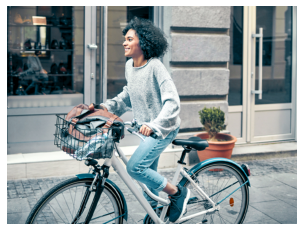

In [41]:
full_image_path = '../test_images/bicycle2.jpg'
#full_image_path = 'agriculture_images/tarla3.jpg'
image_raw = Image.open(full_image_path).convert('RGB')
plt.axis('off')
plt.imshow(image_raw)

### PyTorch deep learning models expect a tensor as input

In [42]:
# Convert raw image to tensor
# https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
img_transforms = transforms.Compose([
    transforms.ToTensor(),
])

### Add batch dimension (models expect it)
### (C, H, W) -> (N, C, H, W)

In [43]:
# Use .unsqueeze(0) to add dummy batch dimension
image_tensor = img_transforms(image_raw).unsqueeze(0)
image_tensor.shape

torch.Size([1, 3, 549, 732])

### Make prediction with pretrained model

In [44]:
predictions = model(image_tensor)
len(predictions)

1

### Model predicts:
* Boxes: bounding box covering the object (xmin, ymix, xmax, ymax)
* Labels: which class (category) it belongs to (see COCO annotation categories)
* Scores: Prediction confidence for each predicted category and bounding box

In [45]:
predictions[0]

{'boxes': tensor([[ 70.0748, 303.8663, 617.7615, 539.7578],
         [475.5911, 252.6127, 572.8959, 391.8304],
         [176.2252,  24.4716, 440.0046, 523.3490],
         [128.0166, 137.2143, 154.3250, 210.8972],
         [131.7844, 257.3450, 291.6337, 356.5879],
         [418.0466, 322.4661, 611.8458, 541.6296],
         [ 45.9593, 119.2091, 102.5000, 172.5549],
         [128.8075, 137.7401, 153.2768, 172.4811],
         [ 34.6932, 281.0619, 352.4395, 544.2343],
         [135.5858, 261.6192, 272.2915, 345.5657],
         [106.2703, 132.4282, 131.7021, 208.6779],
         [ 18.2096, 172.6370, 122.9725, 226.3754],
         [452.5403, 311.2616, 576.3117, 394.9402],
         [223.1184, 281.9884, 477.0303, 542.4526],
         [ 13.8706, 171.0263,  48.0369, 224.6152],
         [ 21.8828, 153.4985, 101.6292, 224.0924],
         [ 41.6257, 116.3876, 109.3134, 216.2074],
         [ 43.4976, 125.3846, 101.4327, 172.1844],
         [ 11.5342, 116.2335,  42.9303, 172.1772],
         [106.8801, 12

In [46]:
predictions[0].keys()

dict_keys(['boxes', 'labels', 'scores'])

In [47]:
all_boxes = predictions[0]['boxes']
all_labels = predictions[0]['labels']
all_scores = predictions[0]['scores']

### Select high confidence (score) predictions

In [63]:
threshold = 0.65
high_confidence_indexes = torch.where(all_scores > threshold)
high_confidence_indexes

(tensor([0, 1, 2, 3, 4]),)

In [64]:
high_confidence_boxes = all_boxes[high_confidence_indexes]
high_confidence_boxes

tensor([[ 70.0748, 303.8663, 617.7615, 539.7578],
        [475.5911, 252.6127, 572.8959, 391.8304],
        [176.2252,  24.4716, 440.0046, 523.3490],
        [128.0166, 137.2143, 154.3250, 210.8972],
        [131.7844, 257.3450, 291.6337, 356.5879]], grad_fn=<IndexBackward0>)

In [65]:
high_confidence_labels = all_labels[high_confidence_indexes]
high_confidence_labels.tolist()

[2, 64, 1, 1, 27]

In [66]:
high_confidence_labels_str = [idx_to_classname[idx] for idx in high_confidence_labels.tolist()]

## Plot bounding boxes on top of the input image
#### draw_bounding_boxes: torchvision utility function (works with tensors)

In [67]:
img_with_boxes = draw_bounding_boxes(
    read_image(full_image_path), 
    high_confidence_boxes, 
    labels=high_confidence_labels_str,
    colors=['blue']*len(high_confidence_boxes), 
    width=4
)

#### Note that function returns tensors as well, you need to convert back to raw image (numpy array) for matplotlib

In [68]:
# Detach from backpropagation compute graph
img_with_boxes = img_with_boxes.detach()
# Convert back to raw image
img_with_boxes = transforms_f.to_pil_image(img_with_boxes)

Total objects found: 5


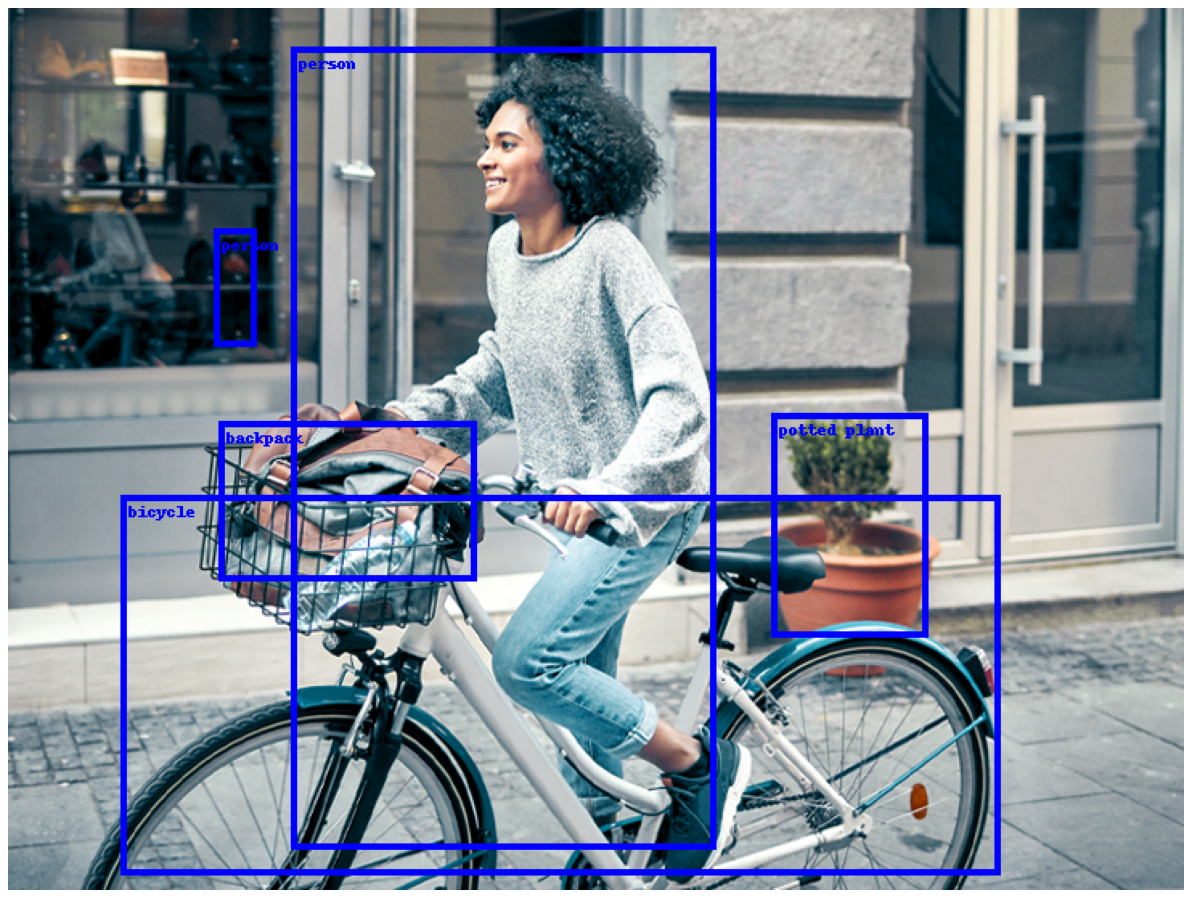

In [69]:
print('Total objects found:', len(high_confidence_labels))
plt.figure(figsize=(15, 15), dpi=80)
plt.axis('off')
plt.tight_layout()
plt.imshow(np.asarray(img_with_boxes))

# Video frames
#### show_bounding_boxes() is written using opencv, works with numpy arrays (tensors are not necessery in this case)

In [70]:
def show_bounding_boxes(image, annotations, class_names, confidence_threshold=None):
    """
    image: image tensor
    annotations: dictionary containing annotations (bbox, labels, etc.)
    confidence_threshold: prediction confidence (between 0.0-1.0)
    """
    # H, W, C -> C, H, W
    #mg_copy = np.array(image.permute(1, 2, 0).numpy().copy())
    img_copy = image
    all_boxes = annotations['boxes']
    all_labels = annotations['labels']

    if confidence_threshold:
        # Select predictions above the threshold
        all_scores = annotations['scores']
        high_confidence_idx = torch.where(all_scores>=confidence_threshold)
        all_boxes = all_boxes[high_confidence_idx]
        all_labels = all_labels[high_confidence_idx]
    
    for label, box in zip(all_labels, all_boxes):
        xmin, ymin = int(box[0]), int(box[1])
        xmax, ymax = int(box[2]), int(box[3])
        color = (255, 0, 0)
        class_name =  class_names[label]

        # Draw bounding box
        cv2.rectangle(
            img_copy, 
            (xmin, ymin), 
            (xmax, ymax),
            color=color, 
            thickness=3
        )
        
        # Write class name
        cv2.putText(
            img_copy, 
            class_name, 
            (xmin, ymin-10), 
            cv2.FONT_HERSHEY_SIMPLEX, 
            0.9, 
            color, 
            2
        )
        
    return img_copy
    # Plot the image with bboxes and labels
    #plt.tight_layout()
    #plt.figure(figsize=(10, 10))
    #plt.axis('off')
    #plt.imshow(img_copy)